In [1]:
import torch
torch.cuda.is_available()

True

In [3]:
print(torch.cuda.get_device_name())

NVIDIA GeForce GTX 1650


In [2]:
# Imports
import os
import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Processing category: agri
s1 images: ['ROIs1868_summer_s1_59_p10.png', 'ROIs1868_summer_s1_59_p100.png', 'ROIs1868_summer_s1_59_p1000.png', 'ROIs1868_summer_s1_59_p1001.png', 'ROIs1868_summer_s1_59_p1002.png']...
s2 images: ['ROIs1868_summer_s2_59_p10.png', 'ROIs1868_summer_s2_59_p100.png', 'ROIs1868_summer_s2_59_p1000.png', 'ROIs1868_summer_s2_59_p1001.png', 'ROIs1868_summer_s2_59_p1002.png']...
Processing category: barrenland
s1 images: ['ROIs1970_fall_s1_114_p1.png', 'ROIs1970_fall_s1_114_p10.png', 'ROIs1970_fall_s1_114_p100.png', 'ROIs1970_fall_s1_114_p1000.png', 'ROIs1970_fall_s1_114_p1001.png']...
s2 images: ['ROIs1970_fall_s2_114_p1.png', 'ROIs1970_fall_s2_114_p10.png', 'ROIs1970_fall_s2_114_p100.png', 'ROIs1970_fall_s2_114_p1000.png', 'ROIs1970_fall_s2_114_p1001.png']...
Processing category: grassland
s1 images: ['ROIs1970_fall_s1_115_p100.png', 'ROIs1970_fall_s1_115_p101.png', 'ROIs1970_fall_s1_115_p102.png', 'ROIs1970_fall_s1_115_p103.png', 'ROIs1970_fall_s1_115_p104.png']...

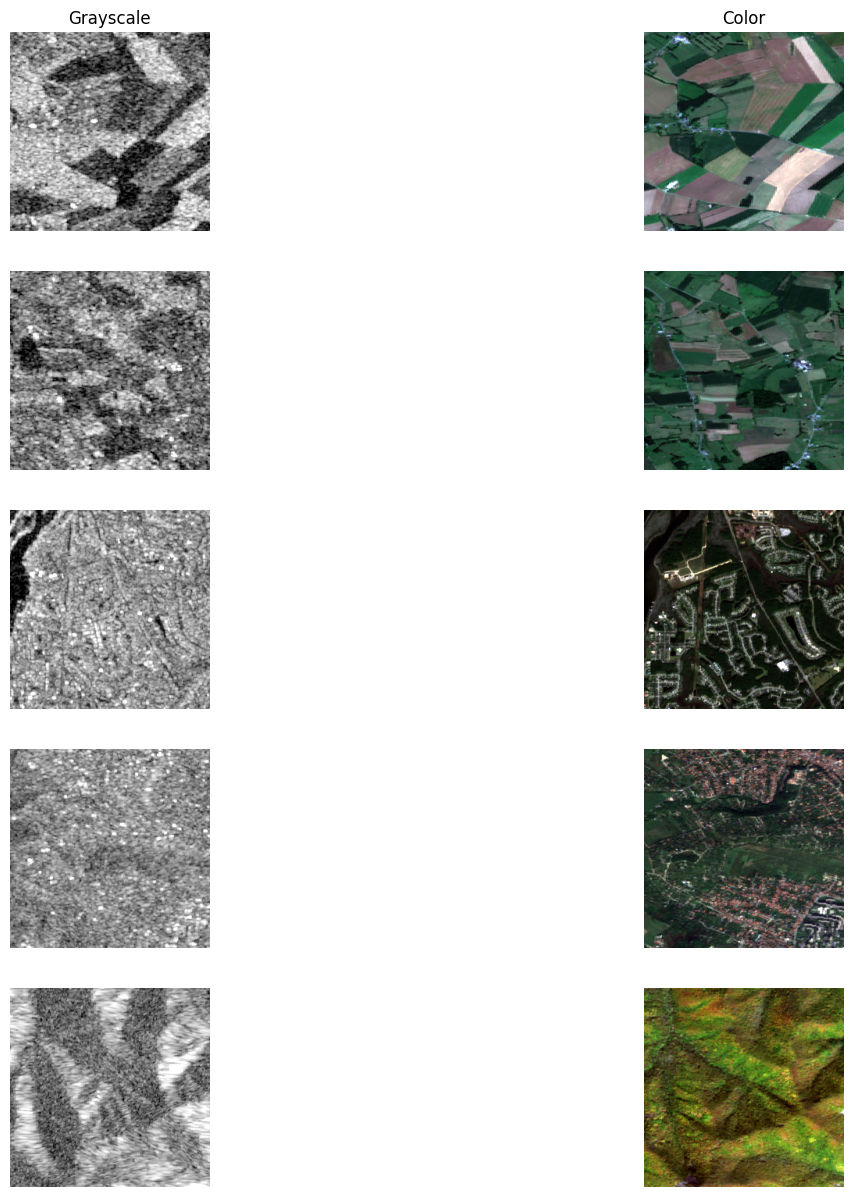

In [3]:
# Data configuration
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

# Updated Dataset Class
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

class SARImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Collect all samples with correct pairs
        for category in ['agri', 'barrenland', 'grassland', 'urban']:
            s1_dir = os.path.join(root_dir, f'v_2/{category}/s1')
            s2_dir = os.path.join(root_dir, f'v_2/{category}/s2')
            s1_images = sorted(os.listdir(s1_dir))
            s2_images = sorted(os.listdir(s2_dir))
            
            # Debugging: Print the files in each directory
            print(f"Processing category: {category}")
            print(f"s1 images: {s1_images[:5]}...")  # Print first 5 filenames for s1
            print(f"s2 images: {s2_images[:5]}...")  # Print first 5 filenames for s2
            
            # Check and match file names
            for s1_file in s1_images:
                # Replace "s1" with "s2" to find the corresponding color image
                s2_file = s1_file.replace('_s1', '_s2')
                if s2_file in s2_images:
                    self.samples.append((os.path.join(s1_dir, s1_file), os.path.join(s2_dir, s2_file)))
                else:
                    # Debugging: Print mismatched files
                    print(f"No match for {s1_file} as {s2_file} in {s2_dir}")

        # Debugging: Print the number of samples found
        print(f"Total samples found: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s1_path, s2_path = self.samples[idx]
        gray_img = read_image(s1_path) / 255.0  # Normalize images to [0, 1]
        color_img = read_image(s2_path) / 255.0  # Normalize images to [0, 1]

        if self.transform:
            gray_img = self.transform(gray_img)
            color_img = self.transform(color_img)

        return color_img, gray_img


# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
])

# Load the dataset
dataset_path = r"F:\My_Projects\Data" # Replace with your dataset path
dataset = SARImageDataset(root_dir=dataset_path, transform=transform)

# Calculate the lengths of the training and testing datasets
total_length = len(dataset)
train_length = int(0.8 * total_length)
test_length = total_length - train_length  # Ensure the lengths sum to the total length

# Split the data into train and test sets
train_set, test_set = random_split(dataset, [train_length, test_length], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Load the train and test data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1, 2, 0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1, 2, 0))
        axs[i, 1].axis('off')
    plt.show()

color, gray = next(iter(trainloader))
show_images(color, gray)

In [23]:
# # Training Variables
# EPOCHS = 100
# LEARNING_RATE = 0.001
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Autoencoder Model (same as before)
# class ColorAutoEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.down1 = nn.Conv2d(1, 64, 4, stride=2, padding=1)  # Bx64x128x128
#         self.down2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)  # Bx128x64x64
#         self.down3 = nn.Conv2d(128, 256, 4, stride=2, padding=1)  # Bx256x32x32
#         self.down4 = nn.Conv2d(256, 512, 4, stride=2, padding=1)  # Bx512x16x16

#         self.up1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, output_padding=0)  # Bx256x32x32
#         self.up2 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1, output_padding=0)  # Bx128x64x64
#         self.up3 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1, output_padding=0)  # Bx64x128x128
#         self.up4 = nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1, output_padding=0)  # Bx3x256x256

#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         d1 = self.relu(self.down1(x))
#         d2 = self.relu(self.down2(d1))
#         d3 = self.relu(self.down3(d2))
#         d4 = self.relu(self.down4(d3))
        
#         print(f"d1 size: {d1.size()}")
#         print(f"d2 size: {d2.size()}")
#         print(f"d3 size: {d3.size()}")
#         print(f"d4 size: {d4.size()}")
        
#         u1 = self.relu(self.up1(d4))
#         print(f"u1 size: {u1.size()}")
        
#         u2 = self.relu(self.up2(torch.cat((u1, d3), dim=1)))
#         print(f"u2 size: {u2.size()}")
        
#         u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
#         print(f"u3 size: {u3.size()}")
        
#         u4 = self.sigmoid(self.up4(torch.cat((u3, d1), dim=1)))
#         print(f"u4 size: {u4.size()}")
        
#         return u4

# # Initialize the model
# model = ColorAutoEncoder().to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# criterion = nn.MSELoss()

In [4]:
EPOCHS = 100
LEARNING_RATE = 0.001
DEVICE = 'cuda' 
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Downsample (Encoder) - Deeper and More Filters
        self.down1 = nn.Conv2d(1, 64, 4, stride=2, padding=1)   # Bx64x128x128
        self.down2 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # Bx128x64x64
        self.down3 = nn.Conv2d(128, 256, 4, stride=2, padding=1) # Bx256x32x32
        self.down4 = nn.Conv2d(256, 512, 4, stride=2, padding=1) # Bx512x16x16
        # New layer: adding an extra convolutional block for a deeper model
        self.down5 = nn.Conv2d(512, 1024, 4, stride=2, padding=1) # Bx1024x8x8

        # Upsample (Decoder) - Mirror the Encoder
        self.up1 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)  # Bx512x16x16
        self.up2 = nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1)  # Bx256x32x32
        self.up3 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1)   # Bx128x64x64
        self.up4 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)    # Bx64x128x128
        # New layer: Adding one more upsampling layer
        self.up5 = nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1)     # Bx3x256x256

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        d1 = self.relu(self.down1(x)) # Bx64x128x128
        d2 = self.relu(self.down2(d1)) # Bx128x64x64
        d3 = self.relu(self.down3(d2)) # Bx256x32x32
        d4 = self.relu(self.down4(d3)) # Bx512x16x16
        d5 = self.relu(self.down5(d4)) # Bx1024x8x8
        
        # Decoder
        u1 = self.relu(self.up1(d5))  # Bx512x16x16
        u2 = self.relu(self.up2(torch.cat((u1, d4), dim=1))) # Bx256x32x32
        u3 = self.relu(self.up3(torch.cat((u2, d3), dim=1))) # Bx128x64x64
        u4 = self.relu(self.up4(torch.cat((u3, d2), dim=1))) # Bx64x128x128
        u5 = self.sigmoid(self.up5(torch.cat((u4, d1), dim=1))) # Bx3x256x256
        
        return u5
model = ColorAutoEncoder().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [59]:
# EPOCHS = 200
# LEARNING_RATE = 0.001
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# class DeeperColorAutoEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Downsample (Encoder) - Adding More Depth
#         self.down1 = nn.Conv2d(1, 64, 4, stride=2, padding=1)   # Bx64x128x128
#         self.down2 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # Bx128x64x64
#         self.down3 = nn.Conv2d(128, 256, 4, stride=2, padding=1) # Bx256x32x32
#         self.down4 = nn.Conv2d(256, 512, 4, stride=2, padding=1) # Bx512x16x16
#         self.down5 = nn.Conv2d(512, 1024, 4, stride=2, padding=1) # Bx1024x8x8
#         self.down6 = nn.Conv2d(1024, 2048, 4, stride=2, padding=1) # Bx2048x4x4
#         self.down7 = nn.Conv2d(2048, 4096, 4, stride=2, padding=1) # Bx4096x2x2
#         self.down8 = nn.Conv2d(4096, 8192, 4, stride=2, padding=1) # Bx8192x1x1

#         # Upsample (Decoder) - Mirror the Encoder
#         self.up1 = nn.ConvTranspose2d(8192, 4096, 4, stride=2, padding=1)  # Bx4096x2x2
#         self.up2 = nn.ConvTranspose2d(8192, 2048, 4, stride=2, padding=1)  # Bx2048x4x4
#         self.up3 = nn.ConvTranspose2d(4096, 1024, 4, stride=2, padding=1)  # Bx1024x8x8
#         self.up4 = nn.ConvTranspose2d(2048, 512, 4, stride=2, padding=1)   # Bx512x16x16
#         self.up5 = nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1)   # Bx256x32x32
#         self.up6 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1)    # Bx128x64x64
#         self.up7 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)     # Bx64x128x128
#         self.up8 = nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1)      # Bx3x256x256

#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # Encoder
#         d1 = self.relu(self.down1(x))  # Bx64x128x128
#         d2 = self.relu(self.down2(d1))  # Bx128x64x64
#         d3 = self.relu(self.down3(d2))  # Bx256x32x32
#         d4 = self.relu(self.down4(d3))  # Bx512x16x16
#         d5 = self.relu(self.down5(d4))  # Bx1024x8x8
#         d6 = self.relu(self.down6(d5))  # Bx2048x4x4
#         d7 = self.relu(self.down7(d6))  # Bx4096x2x2
#         d8 = self.relu(self.down8(d7))  # Bx8192x1x1
        
#         # Decoder
#         u1 = self.relu(self.up1(d8))  # Bx4096x2x2
#         u2 = self.relu(self.up2(torch.cat((u1, d7), dim=1)))  # Bx2048x4x4
#         u3 = self.relu(self.up3(torch.cat((u2, d6), dim=1)))  # Bx1024x8x8
#         u4 = self.relu(self.up4(torch.cat((u3, d5), dim=1)))  # Bx512x16x16
#         u5 = self.relu(self.up5(torch.cat((u4, d4), dim=1)))  # Bx256x32x32
#         u6 = self.relu(self.up6(torch.cat((u5, d3), dim=1)))  # Bx128x64x64
#         u7 = self.relu(self.up7(torch.cat((u6, d2), dim=1)))  # Bx64x128x128
#         u8 = self.sigmoid(self.up8(torch.cat((u7, d1), dim=1)))  # Bx3x256x256
        
#         return u8
# model = DeeperColorAutoEncoder().to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# criterion = nn.MSELoss()

In [8]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

'Total Number of trainable parameters of this model are: 25,044,867'

In [20]:
# best_loss = float('inf')
# patience = 5  # Number of epochs to wait before stopping
# counter = 0

# for epoch in range(EPOCHS):
#     model.train()  # Training phase
#     running_loss = 0.0

#     for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
#         color_img = color_img.to(DEVICE)
#         gray_img = gray_img.to(DEVICE)

#         optimizer.zero_grad()
#         predictions = model(gray_img)
#         loss = criterion(color_img, predictions)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * gray_img.size(0)

#     epoch_loss = running_loss / len(trainloader.dataset)
#     print(f'Epoch: {epoch + 1}, Training Loss: {epoch_loss:.6f}')
    
#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for color_img, gray_img in testloader:
#             color_img = color_img.to(DEVICE)
#             gray_img = gray_img.to(DEVICE)
#             predictions = model(gray_img)
#             val_loss += criterion(color_img, predictions).item() * gray_img.size(0)

#     val_loss /= len(testloader.dataset)
#     print(f'Epoch: {epoch + 1}, Validation Loss: {val_loss:.6f}')
    
#     # Early stopping
#     if val_loss < best_loss:
#         best_loss = val_loss
#         counter = 0  # Reset patience counter
#     else:
#         counter += 1
#         if counter >= patience:
#             print('Early stopping triggered!')
#             break


In [17]:
import matplotlib.pyplot as plt

# Initialize lists to store losses
train_losses = []
val_losses = []

best_loss = float('inf')
patience = 5  # Number of epochs to wait before stopping
counter = 0

for epoch in range(EPOCHS):
    model.train()  # Training phase
    running_loss = 0.0

    # Training loop
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        optimizer.zero_grad()
        predictions = model(gray_img)
        loss = criterion(color_img, predictions)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * gray_img.size(0)

    epoch_loss = running_loss / len(trainloader.dataset)
    train_losses.append(epoch_loss)  # Store the training loss
    print(f'Epoch: {epoch + 1}, Training Loss: {epoch_loss:.6f}')
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for color_img, gray_img in testloader:
            color_img = color_img.to(DEVICE)
            gray_img = gray_img.to(DEVICE)
            predictions = model(gray_img)
            val_loss += criterion(color_img, predictions).item() * gray_img.size(0)

    val_loss /= len(testloader.dataset)
    val_losses.append(val_loss)  # Store the validation loss
    print(f'Epoch: {epoch + 1}, Validation Loss: {val_loss:.6f}')
    
    # Early stopping logic (optional)
    # if val_loss < best_loss:
    #     best_loss = val_loss
    #     counter = 0
    # else:
    #     counter += 1
    #     if counter >= patience:
    #         print('Early stopping triggered!')
    #         break

# After training, plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.010748
Epoch: 1, Validation Loss: 0.017124


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.010777
Epoch: 2, Validation Loss: 0.017366


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.010737
Epoch: 3, Validation Loss: 0.017158


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.010662
Epoch: 4, Validation Loss: 0.017041


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.010505
Epoch: 5, Validation Loss: 0.016989


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.010393
Epoch: 6, Validation Loss: 0.017052


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.010464
Epoch: 7, Validation Loss: 0.016969


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.010406
Epoch: 8, Validation Loss: 0.016998


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.010365
Epoch: 9, Validation Loss: 0.017146


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.010328
Epoch: 10, Validation Loss: 0.016920


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 0.010256
Epoch: 11, Validation Loss: 0.016885


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 0.010151
Epoch: 12, Validation Loss: 0.016831


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 0.010049
Epoch: 13, Validation Loss: 0.016945


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 0.010063
Epoch: 14, Validation Loss: 0.016892


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 0.010058
Epoch: 15, Validation Loss: 0.016866


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 0.010024
Epoch: 16, Validation Loss: 0.016936


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 0.009948
Epoch: 17, Validation Loss: 0.016840


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 0.009911
Epoch: 18, Validation Loss: 0.016902


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 0.009958
Epoch: 19, Validation Loss: 0.016831


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 0.009902
Epoch: 20, Validation Loss: 0.016782


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 0.009847
Epoch: 21, Validation Loss: 0.016916


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 0.009759
Epoch: 22, Validation Loss: 0.016881


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 0.009765
Epoch: 23, Validation Loss: 0.016912


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 0.009764
Epoch: 24, Validation Loss: 0.016734


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 0.009682
Epoch: 25, Validation Loss: 0.016865


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 0.009706
Epoch: 26, Validation Loss: 0.016769


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 0.009702
Epoch: 27, Validation Loss: 0.016825


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 0.009589
Epoch: 28, Validation Loss: 0.016739


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 0.009567
Epoch: 29, Validation Loss: 0.016892


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 30, Training Loss: 0.009539
Epoch: 30, Validation Loss: 0.016833


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 31, Training Loss: 0.009535
Epoch: 31, Validation Loss: 0.016794


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 32, Training Loss: 0.009547
Epoch: 32, Validation Loss: 0.016814


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 33, Training Loss: 0.009452
Epoch: 33, Validation Loss: 0.016715


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 34, Training Loss: 0.009424
Epoch: 34, Validation Loss: 0.016726


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 35, Training Loss: 0.009451
Epoch: 35, Validation Loss: 0.016750


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 36, Training Loss: 0.009460
Epoch: 36, Validation Loss: 0.016753


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 37, Training Loss: 0.009434
Epoch: 37, Validation Loss: 0.016743


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 38, Training Loss: 0.009347
Epoch: 38, Validation Loss: 0.016725


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 39, Training Loss: 0.009309
Epoch: 39, Validation Loss: 0.016746


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 40, Training Loss: 0.009325
Epoch: 40, Validation Loss: 0.016707


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 41, Training Loss: 0.009357
Epoch: 41, Validation Loss: 0.016711


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 42, Training Loss: 0.009309
Epoch: 42, Validation Loss: 0.016753


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 43, Training Loss: 0.009283
Epoch: 43, Validation Loss: 0.016746


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 44, Training Loss: 0.009262
Epoch: 44, Validation Loss: 0.016729


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 45, Training Loss: 0.009288
Epoch: 45, Validation Loss: 0.016673


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 46, Training Loss: 0.009238
Epoch: 46, Validation Loss: 0.016707


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 47, Training Loss: 0.009203
Epoch: 47, Validation Loss: 0.016787


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 48, Training Loss: 0.009185
Epoch: 48, Validation Loss: 0.016685


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 49, Training Loss: 0.009147
Epoch: 49, Validation Loss: 0.016704


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 50, Training Loss: 0.009157
Epoch: 50, Validation Loss: 0.016697


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 51, Training Loss: 0.009104
Epoch: 51, Validation Loss: 0.016664


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 52, Training Loss: 0.009129
Epoch: 52, Validation Loss: 0.016722


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 53, Training Loss: 0.009130
Epoch: 53, Validation Loss: 0.016746


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 54, Training Loss: 0.009177
Epoch: 54, Validation Loss: 0.016850


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 55, Training Loss: 0.009077
Epoch: 55, Validation Loss: 0.016719


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 56, Training Loss: 0.009000
Epoch: 56, Validation Loss: 0.016668


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 57, Training Loss: 0.009018
Epoch: 57, Validation Loss: 0.016723


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 58, Training Loss: 0.009068
Epoch: 58, Validation Loss: 0.016789


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 59, Training Loss: 0.009035
Epoch: 59, Validation Loss: 0.016728


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 60, Training Loss: 0.009015
Epoch: 60, Validation Loss: 0.016709


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 61, Training Loss: 0.008951
Epoch: 61, Validation Loss: 0.016710


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 62, Training Loss: 0.008936
Epoch: 62, Validation Loss: 0.016761


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 63, Training Loss: 0.008978
Epoch: 63, Validation Loss: 0.016738


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 64, Training Loss: 0.008952
Epoch: 64, Validation Loss: 0.016746


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 65, Training Loss: 0.008966
Epoch: 65, Validation Loss: 0.016743


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 66, Training Loss: 0.009040
Epoch: 66, Validation Loss: 0.016802


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 67, Training Loss: 0.008949
Epoch: 67, Validation Loss: 0.016651


  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(original_img, reconstructed_img, win_size=3):
    # Convert images to HxWxC format if they are in CxHxW
    original_img = np.transpose(original_img, (1, 2, 0))  
    reconstructed_img = np.transpose(reconstructed_img, (1, 2, 0))
    
    # Ensure win_size is appropriate for the image size
    min_dim = min(original_img.shape[:2])
    win_size = min(win_size, min_dim)
    
    return ssim(original_img, reconstructed_img, multichannel=True, win_size=win_size, data_range=1.0)

# Example usage in validation loop
ssim_values = []

model.eval()
with torch.no_grad():
    for color_img, gray_img in testloader:
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)
        predictions = model(gray_img)
        
        for i in range(color_img.size(0)):
            original_img = color_img[i].cpu().numpy()  # Move to CPU and convert to numpy
            reconstructed_img = predictions[i].cpu().numpy()  # Move to CPU and convert to numpy
            ssim_value = calculate_ssim(original_img, reconstructed_img)
            ssim_values.append(ssim_value)

average_ssim = np.mean(ssim_values)
print(f'Average SSIM: {average_ssim:.4f}')


Average SSIM: 0.4912


In [45]:
# # Training Loop

# for epoch in range(EPOCHS):
#     running_loss = 0.0
#     model.train()  # Set the model to training mode

#     for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
#         color_img = color_img.to(DEVICE)
#         gray_img = gray_img.to(DEVICE)

#         optimizer.zero_grad()
#         predictions = model(gray_img)
#         loss = criterion(color_img, predictions)  # Ensure the loss function is used correctly
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * gray_img.size(0)  # Accumulate loss

#     epoch_loss = running_loss / len(trainloader.dataset)  # Average loss per epoch
#     print(f'Epoch: {epoch + 1}, Loss: {epoch_loss:.6f}')

# print('Training Finished!')

In [22]:
# Save the trained model
MODEL_PATH = "Newmodel.pth"  # Define your model save path
torch.save(model.state_dict(), MODEL_PATH)
print(f'Model saved to {MODEL_PATH}')

Model saved to Newmodel.pth


In [5]:
model = ColorAutoEncoder()  # Initialize your model class
model.load_state_dict(torch.load("F:\My_Projects\Sih\model.pth"))  # Load the saved state_dict
model.to(DEVICE)  # Move the model to the appropriate device (CPU/GPU)
model.eval()  # Set the model to evaluation mode


<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\SHUVANKAR\AppData\Local\Temp\ipykernel_18728\2833246791.py:2: SyntaxWarning: invalid escape sequence '\M'
  model.load_state_dict(torch.load("F:\My_Projects\Sih\model.pth"))  # Load the saved state_dict
C:\Users\SHUVANKAR\AppData\Local\Temp\ipykernel_18728\2833246791.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the u

ColorAutoEncoder(
  (down1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up2): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up3): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up4): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [6]:
# Testing Loop
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)
        loss = criterion(prediction, color_img)
        total_loss += loss.item()

print(f"Total Testing loss is: {total_loss / len(testloader):.3f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Total Testing loss is: 0.017


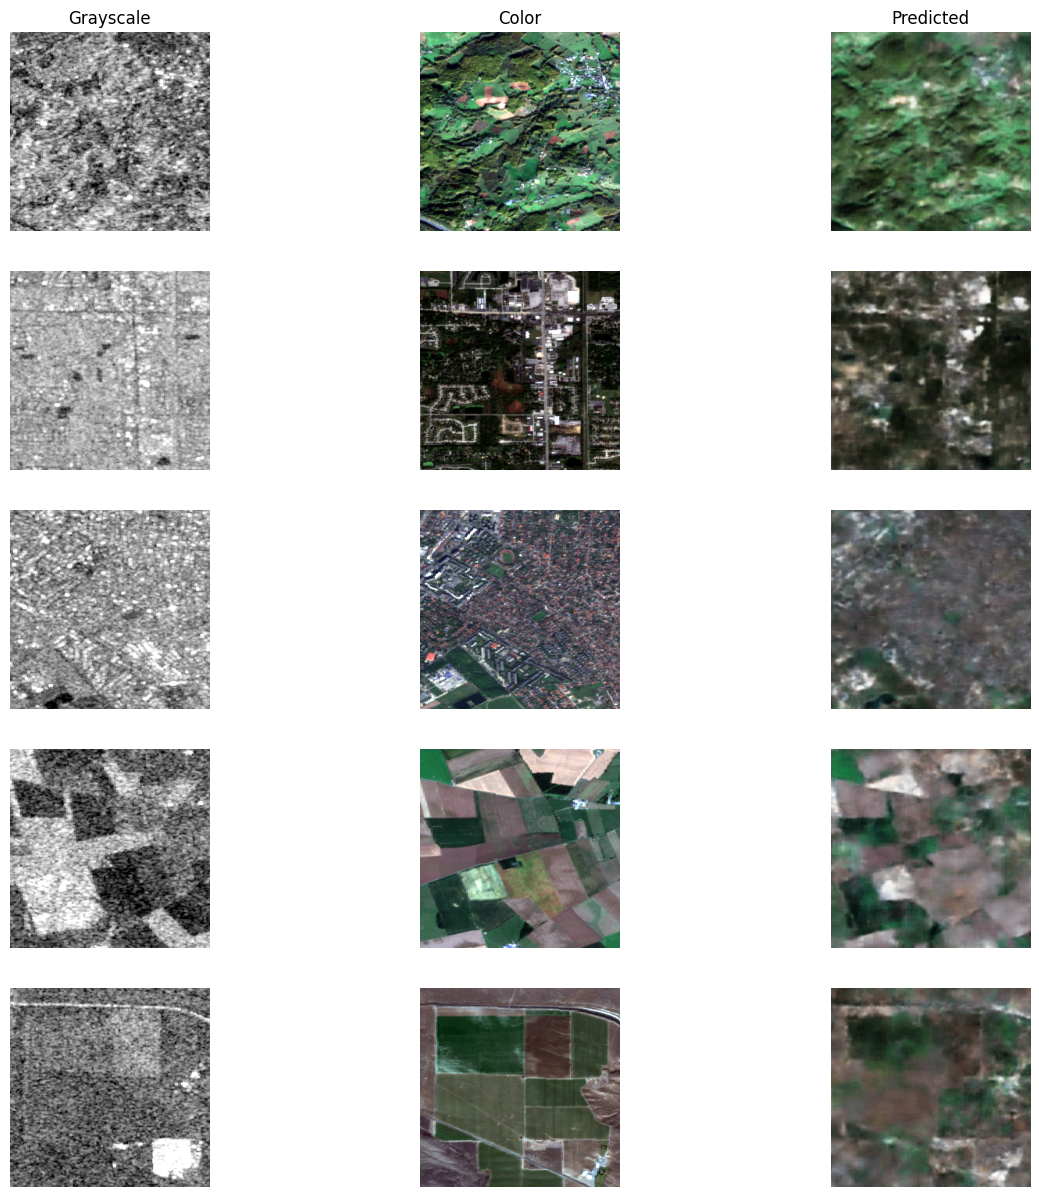

In [20]:
# Visualize predictions
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1, 2, 0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1, 2, 0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1, 2, 0))
    plt.show()

show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu())

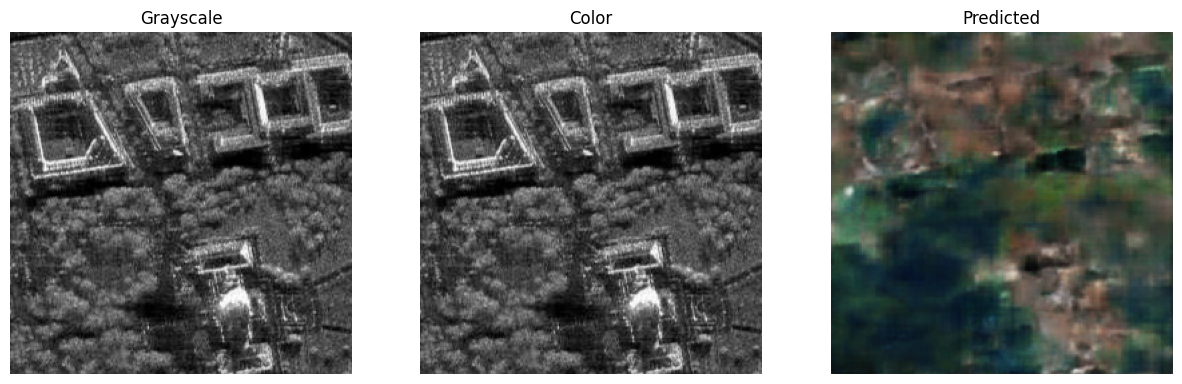

In [7]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, transform=None):
    image = Image.open(image_path).convert("RGB")
    
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
    
    color_img = transform(image)
    
    gray_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    
    gray_img = gray_transform(image)
    
    color_img = color_img.unsqueeze(0)
    gray_img = gray_img.unsqueeze(0)
    
    return color_img, gray_img

def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_title('Grayscale')
    axs[1].set_title('Color')
    axs[2].set_title('Predicted')
    
    axs[0].axis('off')
    axs[0].imshow(gray.permute(1, 2, 0), cmap='gray')
    
    axs[1].axis('off')
    axs[1].imshow(color.permute(1, 2, 0))
    
    axs[2].axis('off')
    axs[2].imshow(pred.permute(1, 2, 0))
    
    plt.show()

# Usage example
image_path = r"F:\libcong.png"
color_img, gray_img = load_and_preprocess_image(image_path)

color_img = color_img.to(DEVICE)
gray_img = gray_img.to(DEVICE)

with torch.no_grad():
    model.eval()
    prediction = model(gray_img)

show_predictions(color_img[0].detach().cpu(), gray_img[0].detach().cpu(), prediction[0].detach().cpu())
